# Manual

In [8]:
import time
import copy
import torch
import torch.nn as nn
from tqdm.notebook import trange
import torch.optim as optim
from util import topk_acc

## data preparation

In [2]:
# 454s
data_pt = torch.load('./data/manual_c.pt')

In [4]:
num = len(data_pt)
train_set, dev_set, test_set = torch.utils.data.random_split(data_pt, [int(num * 0.98), int(num * 0.01), int(num * 0.01)])
datasets = {'train':train_set, 'dev':dev_set, 'test':test_set}
dataset_sizes = {x:len(datasets[x]) for x in ['train', 'dev','test']} 
dataloaders = {x:torch.utils.data.DataLoader(datasets[x], batch_size=1024,
shuffle=True, pin_memory=True) for x in ['train', 'dev', 'test']} 

In [5]:
device = torch.device("cuda")

## FC architecture

In [28]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1_1 = self.fc_block(19, 19)
        self.fc1_2 = self.fc_block(216, 216)
        self.fc1_3 = self.fc_block(128, 128)
        self.fc2 = self.fc_block(363, 256, 0.25)
        self.fc3 = self.fc_block(256, 7, final_layer=True)

    def fc_block(self, input_dims, output_dims, d=0.0, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                    nn.Linear(input_dims, output_dims),
                    nn.Dropout(d),
                    nn.ReLU(True),
                    )
        else:
            return nn.Sequential(
                    nn.Linear(input_dims, output_dims),
                    nn.Dropout(d)
                    )

    def forward(self, x):
        x = torch.split(x, [19, 216, 128] , dim = 1)
        x_1 = self.fc1_1(x[0])
        x_2 = self.fc1_2(x[1])
        x_3 = self.fc1_3(x[2])
        x = torch.cat([x_1, x_2, x_3] , dim = 1)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

net = Net().to(device)

## training

10 5e-2 0.98
10 1e-2

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.98)

In [30]:
sta = {x :{'epoch_acc':[], 'epoch_loss':[]} for x in ['train','dev']}

In [36]:
num_epochs = 10

In [32]:
best_acc = 1 / 7

In [37]:
for epoch in trange(num_epochs):
    for phase in ['train', 'dev']:
        if phase == 'train':
            net.train()  
        else:
            net.eval()   
        running_loss = 0.0
        running_corrects = 0
        for batch in dataloaders[phase]:
            
            inputs, labels = batch[0].to(device), batch[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                top_acc = topk_acc(outputs, labels, 2)
                loss = criterion(outputs, labels)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += top_acc

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]


        # statistics recording
        sta[phase]['epoch_acc'].append(epoch_acc)
        sta[phase]['epoch_loss'].append(epoch_loss)

        # show the current dev acc and time
        if phase == 'dev':
            print(epoch_acc, time.strftime("%H:%M:%S", time.localtime()))
        # record parameters of the best net
        if phase == 'dev' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_net_wts = copy.deepcopy(net.state_dict())

  0%|          | 0/10 [00:00<?, ?it/s]

0.8584333333333334 17:34:51
0.8581833333333333 17:35:40
0.8581 17:36:29
0.8580166666666666 17:37:18
0.85805 17:38:08
0.8588 17:39:03
0.8590833333333333 17:39:51
0.8589833333333333 17:40:40
0.85855 17:41:30
0.85855 17:42:17


In [39]:
net.load_state_dict(best_net_wts)


<All keys matched successfully>

In [14]:
from util import plot_sta, plot_cm

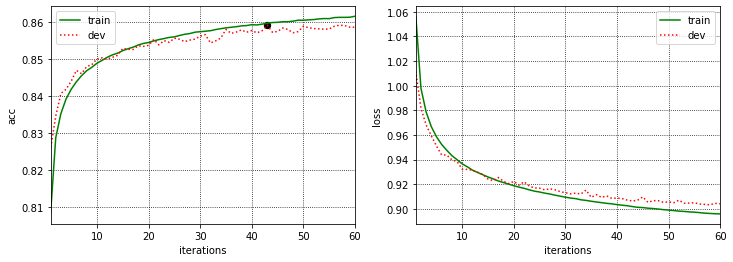

max train acc: 0.8615010204081632
max dev acc: 0.8591 at epoch 43
corresponding train acc: 0.8596113945578231


In [38]:
plot_sta(sta)

In [40]:
net.eval()   
running_corrects = 0
phase = 'test'
with torch.set_grad_enabled(False):
    for batch in dataloaders[phase]:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        outputs = net(inputs)
        top_acc = topk_acc(outputs, labels, 2)
        running_corrects += top_acc
    epoch_acc = running_corrects / dataset_sizes[phase]
epoch_acc

0.8611333333333333

In [41]:
torch.save(sta,'./model/man_c.pt')